# Players Exploration
This notebook analyzes merged player data: distributions, correlations, and country-level market values.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [2]:
# Load merged cleaned dataset
df = pd.read_csv("../Data/Merged/merged_players_clean.csv", encoding="utf-8-sig")
sns.set_theme(style="whitegrid", context="notebook", palette="deep")
df["log_value"] = np.log1p(df["market_value_eur"]) #clear the skewed data and log them to increase the visibility

## Correlations with Market Value

In [3]:

cols = [
    "market_value_eur",
    "overall_rating", "potential",
    "age", "height_cm", "weight_kg",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "power_stamina"
]
df_corr = df[cols].corr()
df_corr["market_value_eur"].sort_values(ascending=False)

market_value_eur             1.000000
overall_rating               0.665794
potential                    0.612018
skill_dribbling              0.240746
attacking_finishing          0.192218
power_stamina                0.130196
defending_standing_tackle    0.095994
height_cm                    0.026637
weight_kg                    0.009467
age                         -0.055058
Name: market_value_eur, dtype: float64

In [4]:
num_cols = [
    "market_value_eur",
    "overall_rating", "potential",
    "age",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "power_stamina"
]

corr = df[num_cols].corr()
corr

,market_value_eur,overall_rating,potential,age,attacking_finishing,skill_dribbling,defending_standing_tackle,power_stamina
market_value_eur,1.000000,0.665794,0.612018,-0.055058,0.192218,0.240746,0.095994,0.130196
overall_rating,0.665794,1.000000,0.691969,0.029395,0.173284,0.219789,0.133738,0.114418
potential,0.612018,0.691969,1.000000,-0.134808,0.119359,0.218176,0.082256,0.064368
age,-0.055058,0.029395,-0.134808,1.000000,-0.113663,-0.136002,-0.030464,-0.106742
attacking_finishing,0.192218,0.173284,0.119359,-0.113663,1.000000,0.840542,0.056918,0.586823
skill_dribbling,0.240746,0.219789,0.218176,-0.136002,0.840542,1.000000,0.402108,0.734382
defending_standing_tackle,0.095994,0.133738,0.082256,-0.030464,0.056918,0.402108,1.000000,0.576279
power_stamina,0.130196,0.114418,0.064368,-0.106742,0.586823,0.734382,0.576279,1.000000


## Distributions

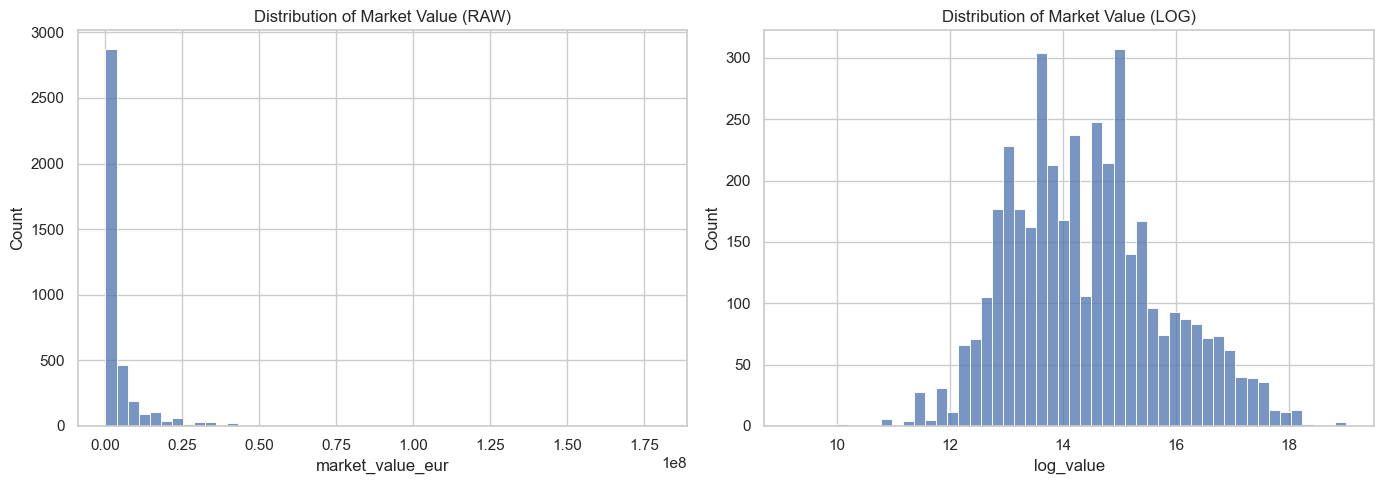

In [5]:

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df["market_value_eur"], bins=50, ax=axes[0])
axes[0].set_title("Distribution of Market Value (RAW)")

sns.histplot(df["log_value"], bins=50, ax=axes[1])
axes[1].set_title("Distribution of Market Value (LOG)")

plt.tight_layout()
plt.show()

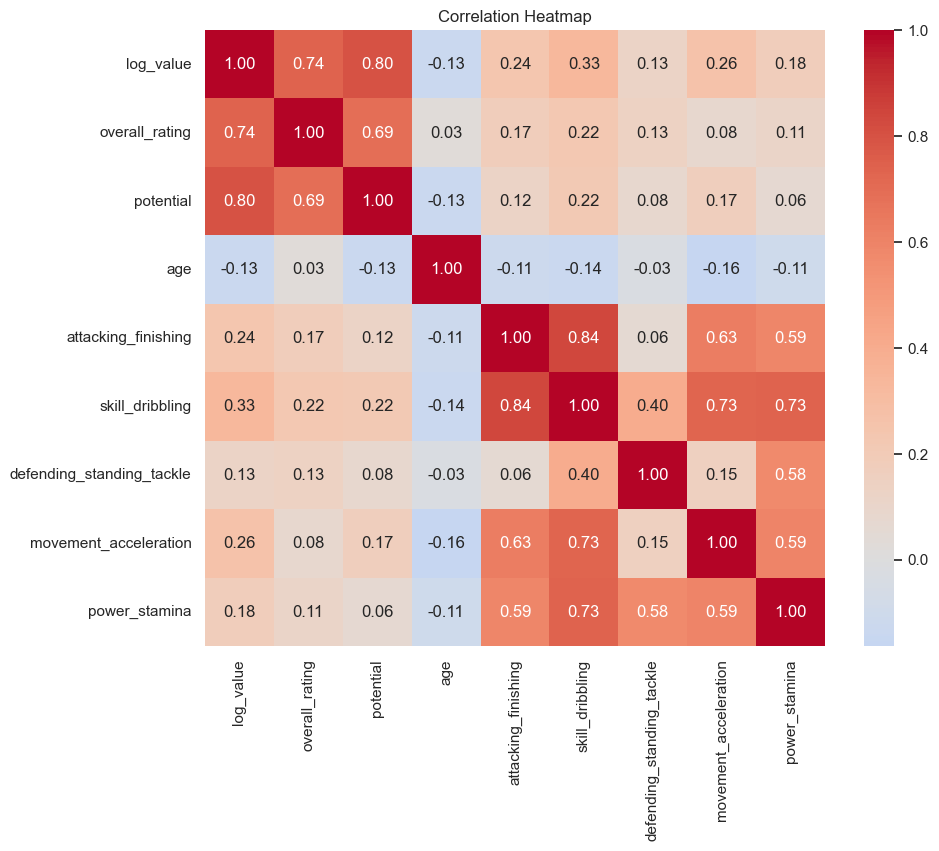

In [ ]:
# Correlations (Heatmap)
cols = [
    "log_value",
    "overall_rating", "potential", "age",
    "attacking_finishing", "skill_dribbling",
    "defending_standing_tackle", "movement_acceleration",
    "power_stamina"
]

corr = df[cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap="coolwarm", center=0
)
plt.title("Correlation Heatmap")
plt.show()

## Country-Level View

In [7]:

country_avg = (
    df.groupby("country_name")["market_value_eur"]
    .mean()
    .reset_index()
)

fig = px.choropleth(
    country_avg,
    locations="country_name",
    locationmode="country names",
    color="market_value_eur",
    hover_name="country_name",
    color_continuous_scale="Viridis",
    title="Average Market Value by Country",
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Avg Market Value (€)")
)

fig.show()

## Top Players per Country (Hover)

In [8]:
# Build a "top players" hover text

def top_players(country, n=3):
    players = (
        df[df["country_name"] == country]
        .sort_values("market_value_eur", ascending=False)
        .head(n)
    )
    return "<br>".join(
        f"{row['full_name']} — €{int(row['market_value_eur']):,}"
        for _, row in players.iterrows()
    )

country_avg["top_players"] = country_avg["country_name"].apply(top_players)

In [9]:
fig = px.choropleth(
    country_avg,
    locations="country_name",
    locationmode="country names",
    color="market_value_eur",
    hover_name="country_name",
    hover_data={"top_players": True, "market_value_eur": False},
    color_continuous_scale="Plasma",
    title="Average Market Value + Top Players by Country",
)

fig.show()

## features reduction suggestions 

since there are a lot of features (190+) this is a concise feature reduction recommendation to readuce the features up to 62 important features

In [10]:
# Convert dob -> age if not already done
if "age" not in df.columns and "dob" in df.columns:
    df["dob"] = pd.to_datetime(df["dob"], errors="coerce", dayfirst=True)
    df["age"] = 2025 - df["dob"].dt.year

# Final feature list
features = [
    # Core bio
    "height_cm", "weight_kg", "age",
    "preferred_foot", "weak_foot", "skill_moves",
    "international_reputation",

    # Overall + potential
    "overall_rating", "potential",

    # Attacking
    "attacking_crossing", "attacking_finishing",
    "attacking_heading_accuracy", "attacking_short_passing",
    "attacking_volleys",

    # Skill
    "skill_dribbling", "skill_curve", "skill_fk_accuracy",
    "skill_long_passing", "skill_ball_control",

    # Movement
    "movement_acceleration", "movement_sprint_speed",
    "movement_agility", "movement_reactions",
    "movement_balance",

    # Power
    "power_shot_power", "power_jumping", "power_stamina",
    "power_strength", "power_long_shots",

    # Mentality
    "mentality_aggression", "mentality_interceptions",
    "mentality_vision", "mentality_penalties",
    "mentality_composure", "mentality_attack_position",

    # Defending
    "defending_defensive_awareness", "defending_standing_tackle",
    "defending_sliding_tackle",

    # Positional ratings
    "CAM", "CB", "CDM", "CM", "LB", "LM", "LW", "RB", "RM", "RW", "ST",
    "CAM.1", "CB.1", "CDM.1", "CM.1", "LB.1", "LM.1", "LW.1",
    "RB.1", "RM.1", "RW.1", "ST.1",

    # Contextual
    "country_name", "club_league_id",

    # Target
    "market_value_eur"
]

# Create the final filtered DataFrame
df_final = df[features].copy()

df_final.head()

,height_cm,weight_kg,age,preferred_foot,weak_foot,skill_moves,international_reputation,overall_rating,potential,attacking_crossing,...,LB.1,LM.1,LW.1,RB.1,RM.1,RW.1,ST.1,country_name,club_league_id,market_value_eur
0,182.0,81.0,26.0,Right,4,5,5,91,94,78,...,0,0,0,0,0,0,1,France,53.0,180000000.0
1,186.0,75.0,22.0,Right,4,4,5,90,94,66,...,0,0,0,0,0,0,0,England,53.0,180000000.0
2,195.0,94.0,25.0,Left,3,3,5,90,92,58,...,0,0,0,0,0,0,1,Norway,13.0,180000000.0
3,178.0,67.0,28.0,Left,5,5,5,90,90,80,...,0,0,0,0,0,0,1,France,16.0,100000000.0
4,182.0,78.0,27.0,Right,4,3,4,89,90,78,...,0,0,0,0,0,0,0,Uruguay,53.0,130000000.0


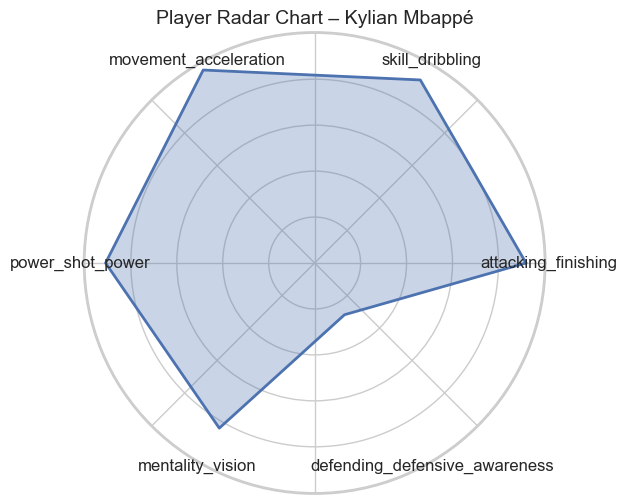

In [26]:
from math import pi
import matplotlib.pyplot as plt

# stats to compare
stats = ["attacking_finishing", "skill_dribbling", "movement_acceleration",
         "power_shot_power", "mentality_vision", "defending_defensive_awareness"]

player = df[df["full_name"] == "Kylian Mbappé"].iloc[0]

# Extract values
values = [player[s] for s in stats]
values += values[:1]  # close the loop

# Compute angles
angles = [n / float(len(stats)) * 2 * pi for n in range(len(stats))]
angles += angles[:1]

# Plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Remove angle labels (degrees)
ax.set_xticklabels([])

# Optional: remove radial labels too
ax.set_yticklabels([])

# Draw the polygon
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, alpha=0.3)

# Add stat labels manually around the circle
for angle, label in zip(angles[:-1], stats):
    ax.text(angle, max(values) + 5, label, ha='center', va='center')

plt.title("Player Radar Chart – Kylian Mbappé", fontsize=14)
plt.show()
